In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, warnings
import random
import datetime
import warnings

from tqdm.notebook import tqdm
# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

import lightgbm as lgb

import pickle

warnings.filterwarnings('ignore')

In [2]:
path = '/Users/Pascal Appelbaum/Documents/Test/'
#show datapath
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/Pascal Appelbaum/Documents/Test/building_metadata.csv
/Users/Pascal Appelbaum/Documents/Test/sample_submission.csv
/Users/Pascal Appelbaum/Documents/Test/test.csv
/Users/Pascal Appelbaum/Documents/Test/train.csv
/Users/Pascal Appelbaum/Documents/Test/weather_test.csv
/Users/Pascal Appelbaum/Documents/Test/weather_train.csv


In [3]:
#data import
train_df = pd.read_csv(path + 'train.csv')
building_df = pd.read_csv(path + 'building_metadata.csv')
weather_df = pd.read_csv(path + 'weather_train.csv')

In [4]:
def missing_statistics(df):
    #show missing values
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [5]:
train_df.sample(7)

,building_id,meter,timestamp,meter_reading
1652790,747,0,2016-01-30 23:00:00,21.5833
7601019,677,0,2016-05-21 04:00:00,2.1000
13883617,148,0,2016-09-10 07:00:00,194.2000
17498766,1347,0,2016-11-13 09:00:00,934.0750
17209650,249,3,2016-11-08 06:00:00,76.1985
19682665,1430,2,2016-12-22 13:00:00,439.9160
7295974,656,0,2016-05-15 18:00:00,5.1000


In [6]:
building_df.sample(7)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
331,3,331,Education,288800,1923.0,NaN
266,2,266,Education,30543,NaN,NaN
1393,15,1393,Entertainment/public assembly,151900,1990.0,NaN
1316,14,1316,Entertainment/public assembly,49975,NaN,NaN
427,3,427,Public services,14269,NaN,NaN
145,1,145,Office,14219,NaN,4.0
96,0,96,Lodging/residential,200933,2006.0,NaN


In [7]:
missing_statistics(building_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


In [8]:
weather_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [9]:
weather_df.sample(7)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
42365,4,2016-10-29 08:00:00,17.8,NaN,16.1,0.0,1014.0,0.0,0.0
95566,10,2016-11-27 15:00:00,3.3,NaN,-1.1,0.0,1000.8,180.0,5.1
2463,0,2016-04-12 15:00:00,23.9,2.0,14.4,0.0,1021.5,NaN,3.1
28798,3,2016-04-12 20:00:00,17.2,4.0,-1.7,0.0,1019.9,320.0,8.8
5743,0,2016-08-27 07:00:00,26.1,NaN,22.8,0.0,1014.3,20.0,3.1
106904,12,2016-03-20 14:00:00,8.0,6.0,2.0,NaN,1027.5,290.0,3.0
13236,1,2016-07-05 05:00:00,15.3,NaN,12.6,NaN,1014.6,260.0,5.1


In [10]:
missing_statistics(weather_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,139773,0.00
1,timestamp,0,139773,0.00
2,air_temperature,55,139773,0.04
3,cloud_coverage,69173,139773,49.49
4,dew_temperature,113,139773,0.08
5,precip_depth_1_hr,50289,139773,35.98
6,sea_level_pressure,10618,139773,7.60
7,wind_direction,6268,139773,4.48
8,wind_speed,304,139773,0.22


In [11]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df['square_feet'] =  np.log1p(df['square_feet']**0.5)
    
    # Remove Unused Columns
    #drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    #df = df.drop(drop, axis=1)
    #gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [15]:
weather_df = fill_weather_dataset(weather_df)

In [16]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.60 MB
Decreased by 73.1%


In [17]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
#del weather_df
#gc.collect()

In [18]:
train_df = features_engineering(train_df)

In [21]:
#print("Ratio of available data (not NAN's):")
#data_ratios = train_df.count()/len(train_df)
#data_ratios

In [20]:
missing_statistics(train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,16709167,20216100,82.65
9,air_temperature,0,20216100,0.00


<AxesSubplot:xlabel='primary_use'>

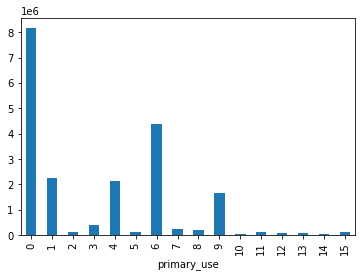

In [27]:
groups = train_df.groupby('primary_use')['primary_use'].count()
groups.plot.bar()